In [32]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [33]:
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 150

## Utils

In [34]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 15))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Datasets retrieval & transformation

In [35]:
# get data
df = pd.read_csv("datasets/nasdaq2007_17.csv", header=None, sep='\t')
df = df.iloc[0, 1:].to_frame("price").astype('float32')
# df.head()

df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df.head()

,price,pct_change,log_ret
1,11.144,NaN,NaN
2,10.471,-0.060391,-0.062292
3,10.828,0.034094,0.033526
4,10.698,-0.012006,-0.012079
5,10.910,0.019817,0.019623


In [36]:
scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1)
                             for i in range(window_length+1, len(df['log_ret']))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1))
                   for i in range(window_length+1, len(df['log_ret']))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)

(3489, 10, 1)
(150, 10, 1)


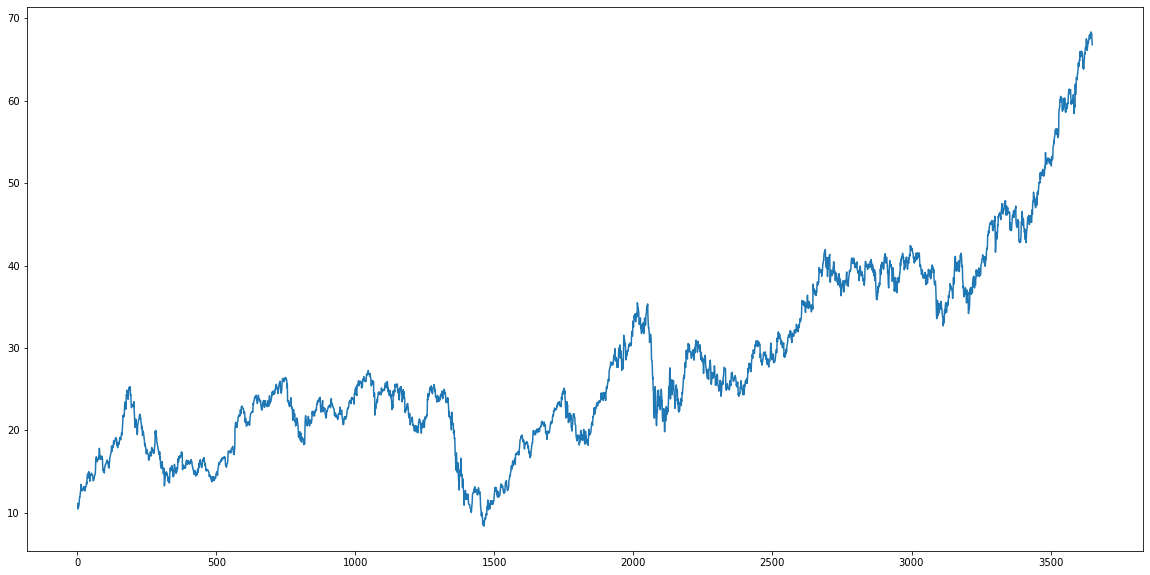

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(df.price)

In [38]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 4.299226139294927%


## 1D Convolutional autoencoder

In [39]:
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length, 1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window)  # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x)  # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x)  # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x)  # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded)  # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)  # 6 dims
x = Conv1D(16, 2, activation='relu')(x)  # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)  # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)  # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                          epochs=epochs,
                          batch_size=1024,
                          shuffle=True,
                          validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_6 (UpSampling1 (None, 6, 1)            

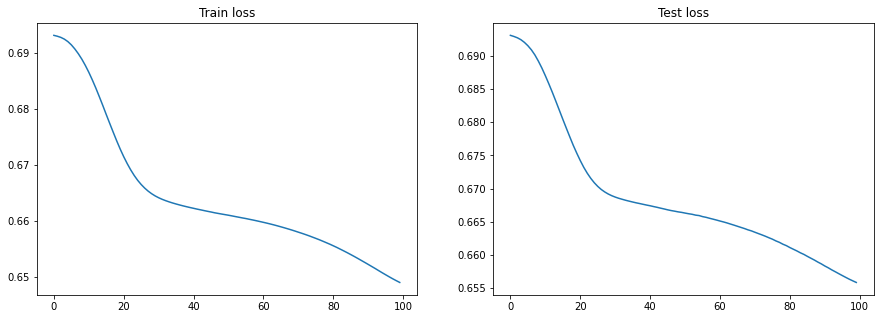

In [40]:
plot_history(history)

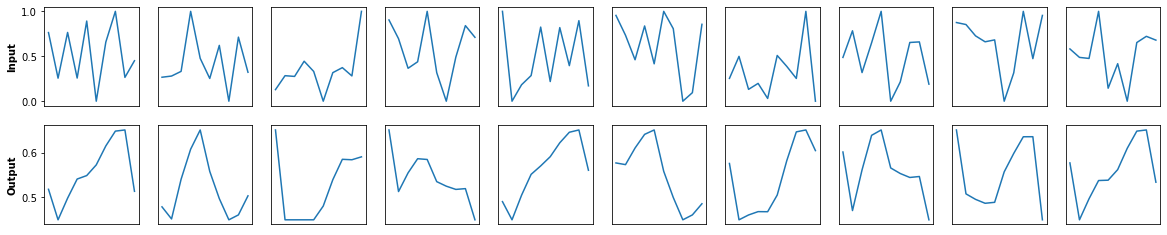

In [41]:
plot_examples(x_test_deep, decoded_stocks)